# PDP - NHANES I

Dans ce TP, nous allons nous concentrer sur le jeu de données <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs/">NHEFS</a> sur la mortalité.

> ⚠️ Il est important de bien comprendre les données et le sujet d'étude pour fournir une interprétabilité cohérente.

In [1]:
!pip install shap pdpbox

In [1]:
 import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from pdpbox import pdp, info_plots

## Chargement des données

In [18]:
X, y = shap.datasets.nhanesi()
y
X = X.iloc[:, 1:]
X.columns = [col.replace(" ", "_") for col in X.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
y

array([ 15.27465753,  11.58607306,   8.14908676, ..., -18.87716895,
       -19.68310502,  17.93858447])

In [3]:
X_train.head()

,Age,Diastolic_BP,Poverty_index,Race,Red_blood_cells,Sedimentation_rate,Serum_Albumin,Serum_Cholesterol,Serum_Iron,Serum_Magnesium,Serum_Protein,Sex,Systolic_BP,TIBC,TS,White_blood_cells,BMI,Pulse_pressure
7198,54.0,96.0,456.0,1.0,60.3,16.0,4.8,307.0,151.0,1.66,7.5,1.0,138.0,344.0,43.9,7.3,29.167065,42.0
9752,68.0,76.0,153.0,1.0,48.4,12.0,4.0,147.0,65.0,1.75,6.2,2.0,124.0,397.0,16.4,8.2,22.540445,48.0
7618,54.0,74.0,584.0,1.0,77.7,1.0,4.1,215.0,48.0,1.70,6.9,1.0,110.0,333.0,14.4,8.7,19.969070,36.0
6636,72.0,88.0,147.0,1.0,47.1,18.0,4.5,208.0,165.0,1.73,7.1,2.0,185.0,281.0,58.7,6.2,18.925149,97.0
109,26.0,80.0,311.0,1.0,77.7,6.0,4.5,260.0,221.0,1.66,7.4,1.0,120.0,363.0,60.9,7.0,23.441069,40.0


In [19]:
y[:5]
#y.shape

array([ 15.27465753,  11.58607306,   8.14908676, -21.09429224,
        -0.        ])

In [5]:
# TODO : Entraîner un XGBoost pour prédire le taux de décès instantanée via une régression de Cox
params = {
    'objective': 'survival:cox',
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'max_depth': 3,
    'eta': 0.002,
    'subsample': 0.5
}
# Paramètre : profondeur maximale 3, eta à 0.002, subsample à 0.5, nombre d'arbres à 2000
# et choisir la bonne fonction objective ...z
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.002, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=0, num_parallel_tree=1,
             objective='survival:cox', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

c_statistic_harrell(model.predict(X_test, ntree_limit=2000), y_test)


0.8340496964728387

## PDP

In [23]:
X_pdp = X_train.iloc[sample_without_replacement(X_train.shape[0], int(X_train.shape[0] * 0.8)), :].dropna()
X_pdp['target'] = model.predict(X_pdp)


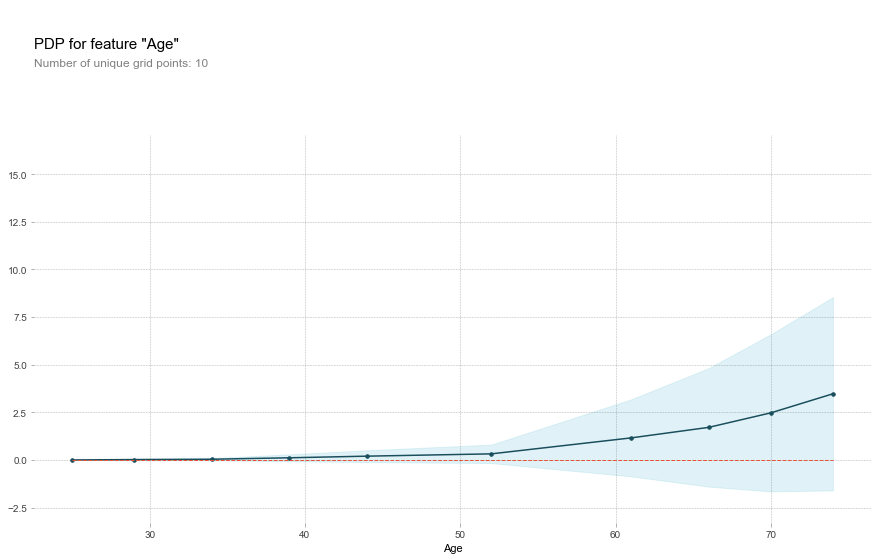

In [24]:
pdpf = pdp.pdp_isolate(
    model=model, dataset=X_pdp, model_features=X.columns, feature='Age'
)
fig, axes = pdp.pdp_plot(pdpf, 'Age')

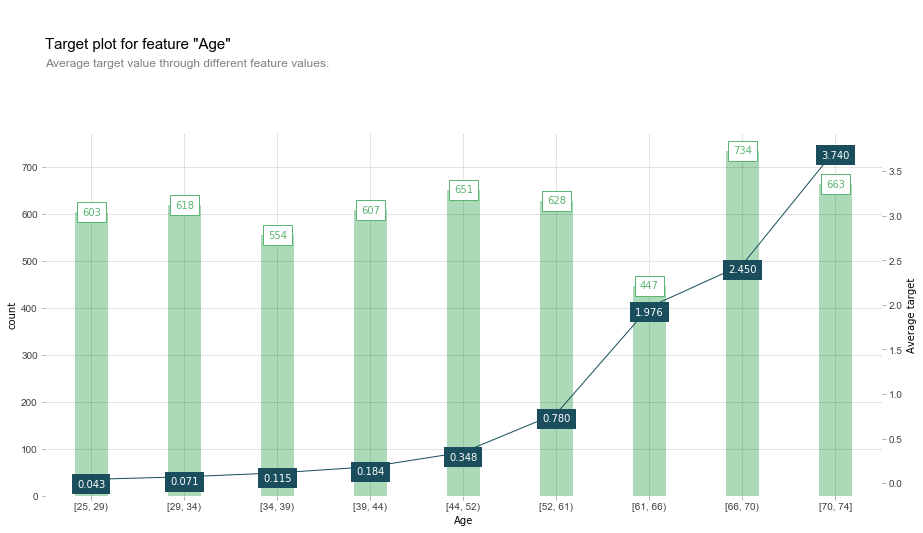

In [18]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_pdp, feature='Age', feature_name='Age', target='target'
)

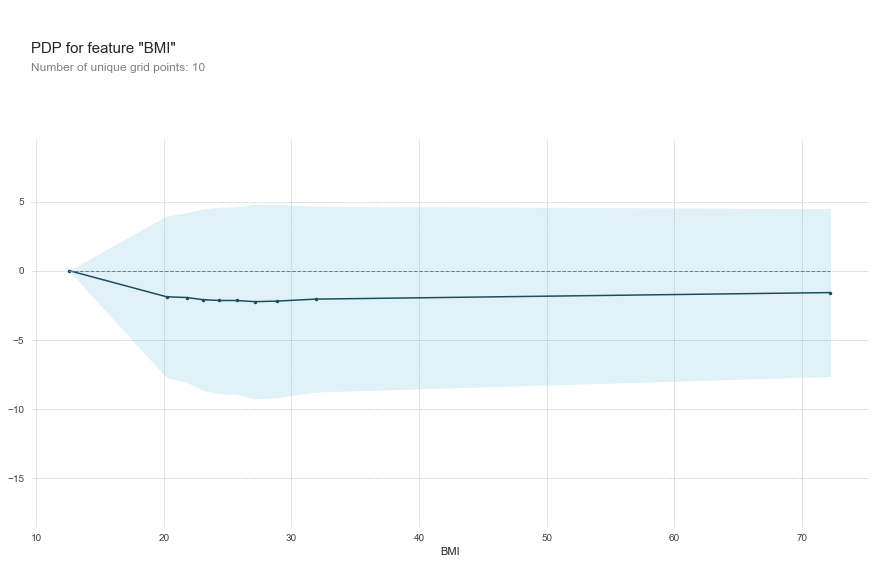

In [15]:
pdpf = pdp.pdp_isolate(
    model=model, dataset=X_pdp, model_features=X.columns, feature='BMI'
)
fig, axes = pdp.pdp_plot(pdpf, 'BMI')

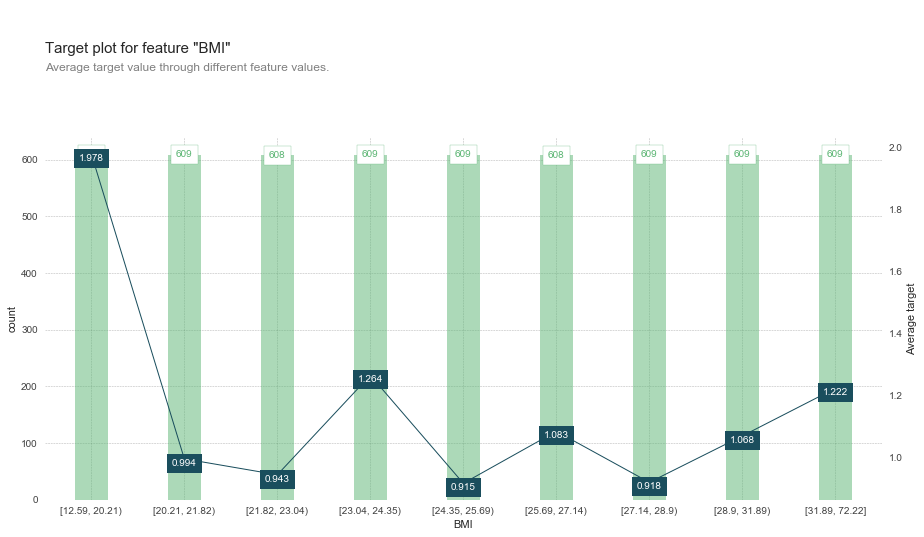

In [16]:
fig, axes, summary_df = info_plots.target_plot(
    df=X_pdp, feature='BMI', feature_name='BMI', target='target'
)

## Interaction croisée

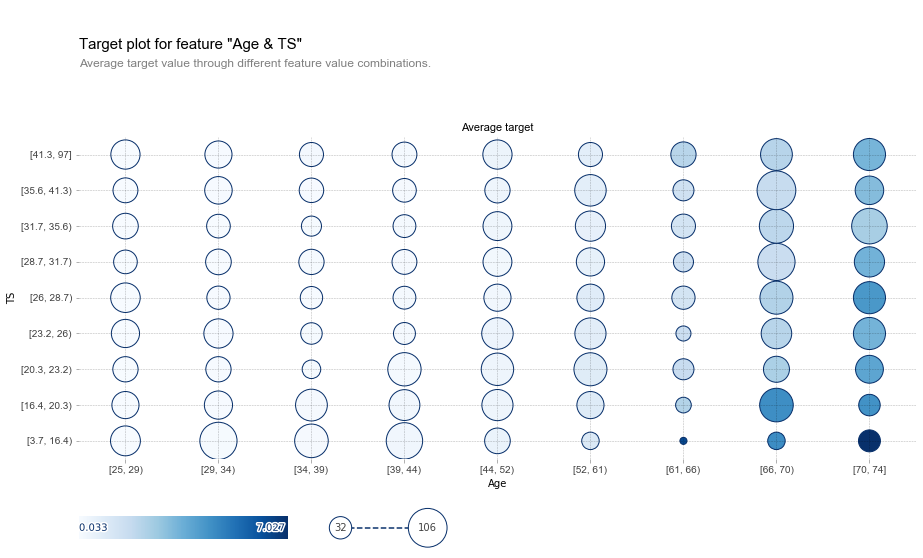

In [20]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=X_pdp, features=['Age', 'TS'], 
    feature_names=['Age', 'TS'], target='target'
)

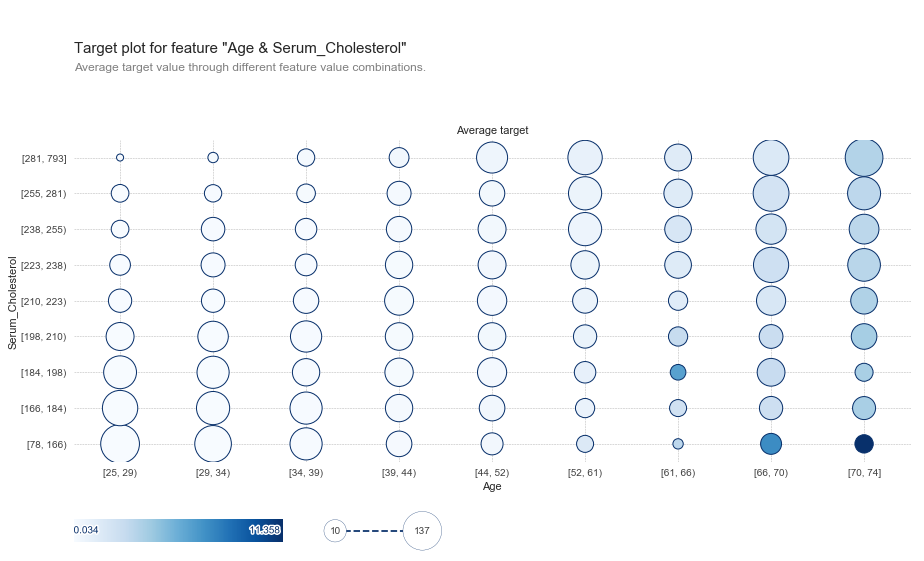

In [18]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=X_pdp, features=['Age', 'Serum_Cholesterol'], 
    feature_names=['Age', 'Serum_Cholesterol'], target='target'
)

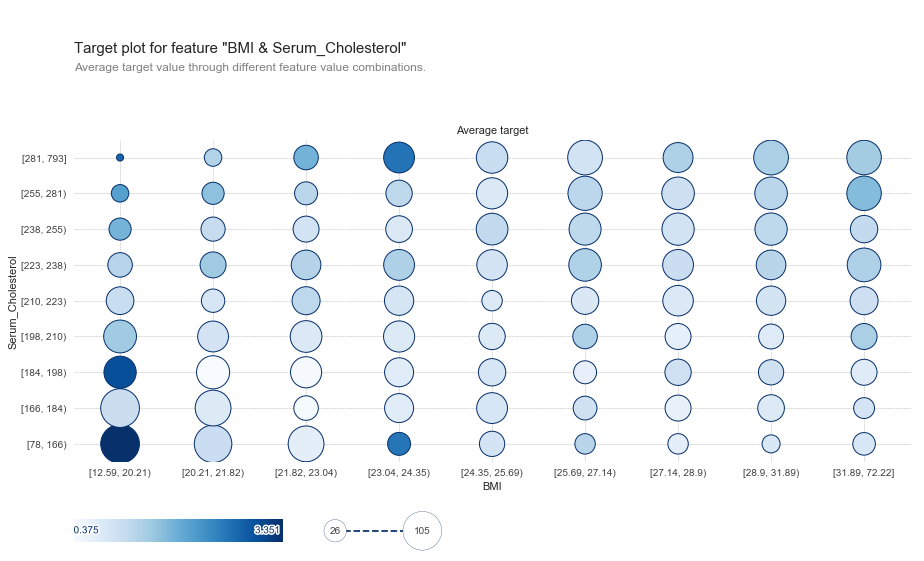

In [19]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=X_pdp, features=['BMI', 'Serum_Cholesterol'], 
    feature_names=['BMI', 'Serum_Cholesterol'], target='target'
)

In [ ]:
import sys
import math

# "CaKe;102,108,111,117,114+101,103,103,115+109,105,108,107" => "Cake ingredients are flour, eggs, milk"

a, b = input().split(";")
a = a.capitalize()

b = ", ".join("".join([chr(int(x)) for x in c.split(",")]) for c in b.split("+"))

print(a, "ingredients are", b)

In [ ]:
import sys
import math

data = input().split(',')
r = ''
for x in range(len(data)):
    if x == 0:
        p=data[x].split(';')
        r+=p[0].capitalize()+" ingredients are "+chr(int(p[1]))
    elif '+' in data[x]:
        p=data[x].split('+')
        r+=chr(int(p[0]))+", "+chr(int(p[1]))
    else:
        r+=chr(int(data[x]))
print(r)


In [ ]:
import sys
import math

# "CaKe;102,108,111,117,114+101,103,103,115+109,105,108,107" => "Cake ingredients are flour, eggs, milk"

data = input().split(';')
s=''
d=data[1].split(',')
for i in d:
    if '+' in i:
        f=i.split('+')
        s+=chr(int(f[0]))
        s+=', '
        s+=chr(int(f[1]))
    else:
        s+=chr(int(i))

print(data[0][0].upper()+data[0][1:].lower()+' ingredients are '+s)